# ssp.train.py

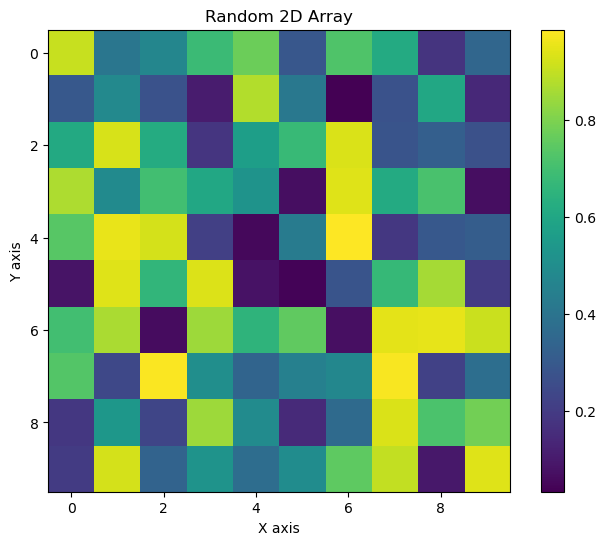

In [1]:
import torch   
import torch.nn as nn 
import torch.nn.functional as F   
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from scipy import io
import itertools
import math
import datetime
import wandb
import pickle
import json
import time
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from snntorch import spikegen


# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈

In [2]:
def cluster_train_system( 
    gpu = '4',
    Conv_net = True,
    SAE_net = True,

    # hyperparameter
    dataset_num = 16,
    spike_length = 50,
    num_cluster = 4,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
    training_cycle = 2400, # 그 초기 몇개까지만 cluster update할지


    batch_size = 32,
    max_epoch = 7000,
    learning_rate = 0.001,
    normalize_on = False, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
    need_bias = False,
    # first_layer_no_train = False
    lif_add_at_first = False,
    my_seed = 42,

    TIME = 10, # SAE일 때만 유효
    v_decay = 0.5,
    v_threshold = 0.5,
    v_reset = 10000.0, # 10000이상 일 시 hard reset
    BPTT_on = True,

    SAE_hidden_nomean = True,
    current_time = '20250101_210938_786',

    optimizer = 'Adam',
    coarse_com_mode = True,
    coarse_com_config = (2.0, -2.0), # (max, min)

    sae_l2_norm_bridge = True,
    sae_lif_bridge = False,

    accuracy_check_epoch_term = 5,
    
    lif_add_at_last = False,

    two_channel_input = False,

    lateral_feature_num = 4,

    lc_adc_on = False, 

    converted_net_forward = False,

    pretrained_net = None, 

    vth_mul_on = False,
    batch_norm_on = False,

    l2_norm_loss_weight = 0.0,

    QCFS_neuron_on = False,

    quantize_level_num = 0,

    fusion_net = False, # True False
    repeat_coding = False,
    ):
    if coarse_com_mode == True:
        assert coarse_com_config[0] > coarse_com_config[1], 'coarse_com_config[0] > coarse_com_config[1]이어야 함'
        assert SAE_net == True, 'coarse_com_mode는 SAE_net이 True일 때만 가능'
    if two_channel_input == True:
        assert Conv_net and coarse_com_mode, 'two_channel_input는 Conv_net이 True일 때만 가능'
    if lc_adc_on == True:
        assert coarse_com_mode and SAE_net, 'lc_adc_on은 coarse_com_mode와 SAE_net이 True일 때만 가능'
    if converted_net_forward == True:
        assert SAE_net == False, 'converted_net_forward는 SAE_net이 False일 때만 가능'
    seed_assign(my_seed)
    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    print(hyperparameters)
    # JSON으로 저장
    with open(f"result_save/cluster_accuracy_history_{current_time}.json", 'w') as f:
        json.dump(hyperparameters, f, indent=4)
    ######################################################################################

    
    wandb.config.update(hyperparameters)
    wandb.run.name = f'{current_time}_SAE_net_{SAE_net}_v_threshold_{v_threshold}'
    wandb.define_metric("best_mean_cluster_accuracy_post_training_cycle_all_dataset2", summary="max")


    my_path_ground_BH = '/data2/spike_sorting/quiroga/BH/'


    filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
                "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
                "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
                "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]


    spike_tot = ["BH_Spike_e1n005.npy", "BH_Spike_e1n010.npy", "BH_Spike_e1n015.npy", "BH_Spike_e1n020.npy",
                "BH_Spike_e2n005.npy", "BH_Spike_e2n010.npy", "BH_Spike_e2n015.npy", "BH_Spike_e2n020.npy",
                "BH_Spike_d1n005.npy", "BH_Spike_d1n010.npy", "BH_Spike_d1n015.npy", "BH_Spike_d1n020.npy",
                "BH_Spike_d2n005.npy", "BH_Spike_d2n010.npy", "BH_Spike_d2n015.npy", "BH_Spike_d2n020.npy"]

    label_tot = ["BH_Label_e1n005.npy", "BH_Label_e1n010.npy", "BH_Label_e1n015.npy", "BH_Label_e1n020.npy",
                "BH_Label_e2n005.npy", "BH_Label_e2n010.npy", "BH_Label_e2n015.npy", "BH_Label_e2n020.npy",
                "BH_Label_d1n005.npy", "BH_Label_d1n010.npy", "BH_Label_d1n015.npy", "BH_Label_d1n020.npy",
                "BH_Label_d2n005.npy", "BH_Label_d2n010.npy", "BH_Label_d2n015.npy", "BH_Label_d2n020.npy"]

    template =  ["BH_Spike_TEMPLATE_e1n005.npy", "BH_Spike_TEMPLATE_e1n010.npy", "BH_Spike_TEMPLATE_e1n015.npy", "BH_Spike_TEMPLATE_e1n020.npy",
                "BH_Spike_TEMPLATE_e2n005.npy", "BH_Spike_TEMPLATE_e2n010.npy", "BH_Spike_TEMPLATE_e2n015.npy", "BH_Spike_TEMPLATE_e2n020.npy",
                "BH_Spike_TEMPLATE_d1n005.npy", "BH_Spike_TEMPLATE_d1n010.npy", "BH_Spike_TEMPLATE_d1n015.npy", "BH_Spike_TEMPLATE_d1n020.npy",
                "BH_Spike_TEMPLATE_d2n005.npy", "BH_Spike_TEMPLATE_d2n010.npy", "BH_Spike_TEMPLATE_d2n015.npy", "BH_Spike_TEMPLATE_d2n020.npy"]

    AE_train_path_gt_detect = 'BH_quiroga_training_dataset_gt_detect.pt' 
    AE_test_path_gt_detect = 'BH_quiroga_test_dataset_gt_detect.pt'

    AE_train_path_real_detect = 'BH_quiroga_training_dataset_real_detect.pt'
    AE_test_path_real_detect = 'BH_quiroga_test_dataset_real_detect.pt'

    AE_train_data = AE_train_path_real_detect #AE_train_path_gt_detect #AE_train_path_real_detect
    AE_test_data = AE_test_path_real_detect #AE_test_path_gt_detect  #AE_test_path_real_detect

    # thr_tot = np.array([0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7])
    cos_thr = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.85, 0.95, 0.9, 0.8, 0.95, 0.95, 0.95, 0.95, 0.8])
    # tem=10
    # cos_thr = np.array([tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, ])

    print('cos_thr', cos_thr)
    
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    if coarse_com_mode == True:
        level_num = TIME
        TIME = spike_length
        spike_length = level_num
        level_interval = (coarse_com_config[0] - coarse_com_config[1]) / (level_num-1)  # max - min
        levels = [coarse_com_config[1] + level_interval * i for i in range(level_num)]
        levels = torch.tensor(levels).to(torch.float).to(device)
        levels = levels.repeat(TIME,1) 
        # print('levels', levels, levels.shape) # TIME, level_num

    n_sample = spike_length

    class spikedataset(Dataset):
        def __init__(self, path, transform = None):    
            self.transform = transform
            self.spike = torch.load(path)
            
        def __getitem__(self, index):
            spike = self.spike[index]            
            if self.transform is not None:
                spike = self.transform(spike)
            return spike
        
        def __len__(self):
            return len(self.spike)

    train_dataset = spikedataset(my_path_ground_BH + AE_train_data)
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

    test_dataset = spikedataset(my_path_ground_BH + AE_test_data)
    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)


    # vth_mul_on = True # True False
    # batch_norm_on = True # True False


    # 모델 초기화
    if SAE_net == False: # 여기서는 l2norm, lif bridge 둘 다 true면 l2norm먼저
        if Conv_net == True:
            input_channels = 2 if two_channel_input else 1
            if fusion_net == True:
                net = FUSION_net_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, 
                                    synapse_fc_trace_const1=1, 
                                    synapse_fc_trace_const2=v_decay, #안씀 
                                    TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                    sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                    sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last, repeat_coding=repeat_coding).to(device)
            else: 
                net = Autoencoder_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, need_bias=need_bias, l2norm_bridge=sae_l2_norm_bridge, relu_bridge=sae_lif_bridge, activation_collector_on=False,
                                        batch_norm_on=batch_norm_on, QCFS_neuron_on=QCFS_neuron_on).to(device)
            net = torch.nn.DataParallel(net)
            if converted_net_forward:
                converted_net = SAE_converted_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, 
                                    synapse_fc_trace_const1=1, 
                                    synapse_fc_trace_const2=v_decay, #안씀 
                                    TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                    sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                    sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last,
                                    vth_mul_on=vth_mul_on, batch_norm_on=batch_norm_on).to(device) # lif bridge는 무조건 들어가게 해놨음.
                converted_net = torch.nn.DataParallel(converted_net)
                print('converted_net', converted_net)
        else:
            net = Autoencoder_only_FC(encoder_ch=[400, lateral_feature_num], decoder_ch=[400,n_sample], n_sample=n_sample, need_bias=need_bias, l2norm_bridge=sae_l2_norm_bridge, relu_bridge=sae_lif_bridge, activation_collector_on=False,
                                    batch_norm_on=batch_norm_on, QCFS_neuron_on=QCFS_neuron_on).to(device)
            net = torch.nn.DataParallel(net)
            if converted_net_forward:
                converted_net = SAE_converted_fc(encoder_ch=[400, lateral_feature_num], 
                                    decoder_ch=[400, n_sample], 
                                    in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
                                    synapse_fc_trace_const1=1,
                                    synapse_fc_trace_const2=v_decay,  #안씀 
                                    TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                    sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                    sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last,
                                    vth_mul_on=vth_mul_on, batch_norm_on=batch_norm_on).to(device) # lif bridge는 무조건 들어가게 해놨음.
                converted_net = torch.nn.DataParallel(converted_net)
                # print('converted_net', converted_net)
    else: # 여기서는 l2norm, lif bridge 둘 다 true면 lif또는 relu먼저
        if Conv_net == True: 
            input_channels = 2 if two_channel_input else 1
            net = SAE_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, 
                                synapse_fc_trace_const1=1, 
                                synapse_fc_trace_const2=v_decay, #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last, batch_norm_on=batch_norm_on).to(device)
            # net = SAE_conv1_DR(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, 
            #                     synapse_fc_trace_const1=1, 
            #                     synapse_fc_trace_const2=v_decay, #안씀 
            #                     TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
            #                     sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
            #                     sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last, batch_norm_on=batch_norm_on).to(device)
            net = torch.nn.DataParallel(net)
        else:
            net = SAE_fc_only(encoder_ch=[400, lateral_feature_num], 
                                decoder_ch=[400, n_sample], 
                                in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
                                synapse_fc_trace_const1=1,
                                synapse_fc_trace_const2=v_decay,  #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last, batch_norm_on=batch_norm_on).to(device)
            net = torch.nn.DataParallel(net)

    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_AE_re_e7000.pth')
    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_20250101_210938_786.pth')
    # load했으면 torch.nn.DataParallel 하지마
    # net.module.load_state_dict(torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_annbase_20250108_210641_941.pth'))
    if pretrained_net != None:
        ######################## 모델이 달라서 dict로 weight만 넣고싶을 때
        # # 저장된 가중치 로드
        saved_state_dict = torch.load(pretrained_net)
        current_state_dict = net.module.state_dict()

        # 함수 호출로 가중치 매핑
        updated_state_dict = map_and_load_weights(saved_state_dict, current_state_dict)

        # 업데이트된 state_dict를 네트워크에 로드
        net.module.load_state_dict(updated_state_dict)
        ######################## 모델이 달라서 dict로 weight만 넣고싶을 때

        ############## 일반적일 때
        # net.module.load_state_dict(torch.load(pretrained_net))
        ############## 일반적일 때
    
        # pre_net = Autoencoder_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, need_bias=need_bias, l2norm_bridge=sae_l2_norm_bridge, relu_bridge=sae_lif_bridge, activation_collector_on=False,
        #                         batch_norm_on=batch_norm_on, QCFS_neuron_on=False).to(device)
        # pre_net = torch.nn.DataParallel(net)
        # pre_net.module.load_state_dict(torch.load(pretrained_net))
        # copy_weights(pre_net.module.encoder , net.module.encoder )
        # copy_weights(pre_net.module.decoder , net.module.decoder  )

        




    wandb.watch(net, log="all", log_freq = 10)





    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__



    net = net.to(device)
    print(f"Total number of encoder parameters: {sum(p.numel() for p in net.module.encoder.parameters())}")
    print(net)
    print('Device:',device)

    
    if optimizer == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    elif optimizer == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)
    else:
        assert False, 'optimizer를 잘못 입력했습니다.'
        
    loss_history = []
    mean_cluster_accuracy_during_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_post_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_total_all_dataset_history = []

    tau = np.zeros(num_cluster)

    print(f"\nStart Training, current_time = {current_time}")
    mean_cluster_accuracy_post_training_cycle_all_dataset = 0
    best_mean_cluster_accuracy_post_training_cycle_all_dataset = 0

    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__
        
    k_means_acc_best = 0
    maxdata = 0
    mindata = 0
    for epoch in range(max_epoch):
        print()
        l2_loss_bin= 0
        ae_train_start_time = time.time()
        running_loss = 0.0
        running_loss_normal = 0.0
        running_loss_coarse = 0.0
        iter = 0
        net.train()
        # if True or max_epoch != 1:
        if max_epoch != 1:
            for data in train_loader:
                optimizer.zero_grad()
                data = data.to(device)
                maxdata= max(maxdata, data.max())
                mindata= min(mindata, data.min())
                data = zero_to_one_normalize_features(data, level_num=quantize_level_num) if normalize_on else data
                spike_backup = data
                spike = data
                spike = spike.to(device) # batch, feature
                if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                    spike = spike.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                    spike = (spike > levels).to(torch.float) 

                    spike = (spike == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike

                    # spike: batch, time, level_num
                    # levels: time, level_num
                    if Conv_net == True:
                        spike = spike.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                        if two_channel_input == True:
                            spike_backup = spike_backup.to(device)
                            spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                            spike_backup = (spike_backup <= levels).to(torch.float) 
                            spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                            spike_backup = spike_backup.unsqueeze(-2)
                            spike = torch.cat((spike, spike_backup), dim=-2)
                    assert spike.shape[0] == batch_size and spike.shape[1] == TIME
                elif 'SAE' in net.module.__class__.__name__:
                    spike = spike.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
                    if Conv_net == True:
                        spike = spike.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                else:
                    if Conv_net == True:
                        spike = spike.unsqueeze(-2) #batch in_channel,feature
                    # if fusion_net == True:
                    #     spike = spikegen.rate(spike, num_steps=TIME).transpose(0, 1)

                # for i in range (3):
                #     plot_spike(spike[i,:,0,:].cpu().numpy())
                #     plot_spike(spike[i,:,1,:].cpu().numpy())
                # assert False
                        
                # spike_class = net(spike) # batch, time, feature
                encoded_spike = net.module.encoder(spike)
                spike_class = net.module.decoder(encoded_spike)

                loss = 0
                loss_normal = torch.tensor(0.0)
                loss_coarse = torch.tensor(0.0)
                if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                    criterion = nn.MSELoss().to(device)
                    # loss1 = nn.MSELoss()(spike_class[..., 5:25], spike[..., 5:25])
                    # loss2 = nn.MSELoss()(spike_class[..., 0:5], spike[..., 0:5])
                    # loss3 = nn.MSELoss()(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                    # loss = loss1 * 2.125 + (loss2 + loss3)/4

                    # loss1 = nn.MSELoss()(spike_class[..., 5:25, :], spike[..., 5:25, :])
                    # loss2 = nn.MSELoss()(spike_class[..., 0:5, :], spike[..., 0:5, :])
                    # loss3 = nn.MSELoss()(spike_class[..., 25:spike_length, :], spike[..., 25:spike_length, :])
                    # loss = loss1 * 2.125 + (loss2 + loss3)/4

                    loss = criterion(spike_class, spike)
                elif 'SAE' in net.module.__class__.__name__:
                    criterion = nn.MSELoss().to(device)
                    loss1 = criterion(spike_class[..., 5:25], spike[..., 5:25])
                    loss2 = criterion(spike_class[..., 0:5], spike[..., 0:5])
                    loss3 = criterion(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                    loss = loss1 * 2.125 + (loss2 + loss3)/4
                    assert spike_length > 25, 'spike_length가 25보다 작음'
                else:
                    criterion = nn.MSELoss().to(device)
                    loss1 = criterion(spike_class[..., 5:25], spike[..., 5:25])
                    loss2 = criterion(spike_class[..., 0:5], spike[..., 0:5])
                    loss3 = criterion(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                    loss = loss1 * 2.125 + (loss2 + loss3)/4
                    assert spike_length > 25, 'spike_length가 25보다 작음'

                    if l2_norm_loss_weight > 0:
                        assert len(encoded_spike.shape) == 2, 'time 성분 없는 걸로'
                        l2_loss = l2_norm_loss(encoded_spike, target_norm=1.0)  # L2Norm Loss 계산, l2 1.0되게.
                        loss = loss + l2_loss*l2_norm_loss_weight
                        l2_loss_bin += l2_loss.item()

                    # coarse loss ######################################################
                    loss_normal = criterion(spike_class, spike)
                    level_num_in_loss = quantize_level_num
                    level_interval = (coarse_com_config[0] - coarse_com_config[1]) / (level_num_in_loss-1)  # max - min
                    levels = [coarse_com_config[1] + level_interval * i for i in range(level_num_in_loss)]
                    levels = torch.tensor(levels).to(torch.float).to(device)
                    levels = levels.repeat(spike_length,1) 

                    spike = spike.squeeze()
                    spike_class = spike_class.squeeze()
                    # plot_origin_spike(spike_class[0].cpu().detach().numpy())
                    spike = spike.unsqueeze(2).repeat(1, 1, level_num_in_loss) 
                    spike = (spike > levels).to(torch.float) 
                    spike_class = spike_class.unsqueeze(2).repeat(1, 1, level_num_in_loss) 
                    spike_class = (spike_class > levels).to(torch.float) 

                    loss_coarse = criterion(spike_class, spike)

                    # plot_spike(spike_class[0].cpu().detach().numpy())
                    # assert False
                    # coarse loss ######################################################

                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                running_loss_normal += loss_normal.item()
                running_loss_coarse += loss_coarse.item()
                # print(f'\nepoch-{epoch}, running_loss : {running_loss:.5f}, iter percent {iter/len(train_loader)*100:.2f}%')
                iter += 1
        else:
            print('\n\n\n max_epoch 1이면 Train 안함!!!!!!!!!!!!!!!!!!!!!')
        if l2_norm_loss_weight > 0:
            print('l2_loss_bin', l2_loss_bin/len(train_loader))
        avg_loss = running_loss / len(train_loader)
        assert not np.isnan(avg_loss), f"Error: avg_loss is NaN! Running loss: {running_loss}, Length of train_loader: {len(train_loader)}"
        loss_history.append((epoch, avg_loss))
        print(f'\nepoch-{epoch} loss : {avg_loss:.8f}, loss_normal : {running_loss_normal/len(train_loader):.8f}, loss_coarse : {running_loss_coarse/len(train_loader):.8f}')
        print(f"ae train 실행 시간: {time.time()-ae_train_start_time:.3f}초, 전체 시작 시간 {current_time}")
        print(f"maxdata: {maxdata}, mindata: {mindata}")

        # plot_activation_distribution(net)

        if SAE_net == False and converted_net_forward == True:
            source_encoder = net.module.encoder 
            target_encoder = converted_net.module.encoder  
            copy_weights(source_encoder, target_encoder)

        cluster_accuracy_during_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_post_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_total_all_dataset = np.zeros(dataset_num)    

        k_means_acc = 0
        converted_k_means_acc = 0
        if(epoch % accuracy_check_epoch_term == 0 or epoch == 1 or epoch == max_epoch-1): 
            accuracy_check_start_time = time.time()
            print(f'\nepoch-{epoch} accuracy check')
            k_means_bin_origin_feature = []
            k_means_bin = []
            converted_k_means_bin = []
            for ds in range(dataset_num):
                # print('\n', spike_tot[ds])

                spike_template = np.load(my_path_ground_BH + template[ds])
                spike = np.load(my_path_ground_BH + spike_tot[ds])
                label = np.load(my_path_ground_BH + label_tot[ds])
                spike_template = torch.from_numpy(spike_template).to(device)
                spike = torch.from_numpy(spike).to(device)
                spike_template = zero_to_one_normalize_features(spike_template, level_num=quantize_level_num) if normalize_on else spike_template
                spike = zero_to_one_normalize_features(spike, level_num=quantize_level_num) if normalize_on else spike
                
                hidden_size = lateral_feature_num*TIME if 'SAE' in net.module.__class__.__name__ and SAE_hidden_nomean == True else lateral_feature_num
                hidden_size = lateral_feature_num if '_DR' in net.module.__class__.__name__  else hidden_size

                Cluster = np.zeros((num_cluster, hidden_size))
                assert Cluster.shape[-1] == hidden_size, '이거 hidden dim 4 아니게 할 거면 잘 바꿔라'
                


                net.eval()
                with torch.no_grad():
                    spike_torch = spike_template.float()
                    spike_torch = spike_torch[:num_cluster]
                    spike_backup = spike_torch
                    spike_torch = spike_torch.to(device)
                    if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                        spike_torch = (spike_torch > levels).to(torch.float) 
                        spike_torch = (spike_torch == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_torch
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                            if two_channel_input == True:
                                spike_backup = spike_backup.to(device)
                                spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                                spike_backup = (spike_backup <= levels).to(torch.float) 
                                spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                                spike_backup = spike_backup.unsqueeze(-2) # batch, time, in_channel, feature
                                spike_torch = torch.cat((spike_torch, spike_backup), dim=-2)
                    elif 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(1).repeat(1, TIME, 1) # (batch, time, feature)로 변환
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                    else:
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) #batch in_channel,feature
                        if converted_net_forward == True:
                            spike_torch_spikegen = spikegen.rate(spike_torch, num_steps=TIME).transpose(0, 1)
                        # if fusion_net == True:
                        #     spike_torch = spikegen.rate(spike_torch, num_steps=TIME).transpose(0, 1)
                    ### forward #######################################################
                    inner_inf = net.module.encoder(spike_torch)
                    if SAE_net == False and converted_net_forward == True:
                        converted_inner_inf = converted_net.module.encoder(spike_torch_spikegen)
                    ### forward #######################################################

                    # for i in range(3):
                    #     plot_spike(spike_torch[i,:,:].cpu().numpy())
                    #     plot_spike(inner_inf[i,:].cpu().numpy())
                    #     plot_spike(net.module.decoder(inner_inf)[i,:,:].cpu().numpy())
                        
                    # if 'SAE' in net.module.__class__.__name__:
                    #     tensors = [inner_inf[0][i] for i in range(TIME)] 
                    #     all_equal = all(torch.equal(tensors[0], t) for t in tensors)
                    #     print(all_equal, inner_inf)

                    if 'SAE' in net.module.__class__.__name__:
                        if SAE_hidden_nomean == True:
                            inner_inf = inner_inf.reshape(inner_inf.shape[0],-1)# time*feature 펼치기
                        else:
                            inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균

                    Cluster = inner_inf.cpu().detach().numpy()

                encoder_batch = 128
                spike_hidden = np.zeros((len(spike), hidden_size))
                converted_spike_hidden = np.zeros((len(spike), hidden_size))
                net.eval()
                with torch.no_grad():
                    now_index = 0
                    while (1):
                        now_end_index = now_index+encoder_batch if now_index+encoder_batch < len(spike) else len(spike)
                        spike_batch = spike[now_index:now_end_index] 
                        spike_torch = spike_batch
                        spike_torch = spike_torch.float()
                        spike_backup = spike_torch
                        spike_torch = spike_torch.to(device)
                        if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                            spike_torch = (spike_torch > levels).to(torch.float) 
                            spike_torch = (spike_torch == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_torch
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                                if two_channel_input == True:
                                    spike_backup = spike_backup.to(device)
                                    spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                                    spike_backup = (spike_backup <= levels).to(torch.float) 
                                    spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                                    spike_backup = spike_backup.unsqueeze(-2)
                                    spike_torch = torch.cat((spike_torch, spike_backup), dim=-2)
                        elif 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(1).repeat(1, TIME, 1) # (batch, time, feature)로 변환
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                        else:
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) #batch in_channel,feature
                            if converted_net_forward == True:
                                spike_torch_spikegen = spikegen.rate(spike_torch, num_steps=TIME).transpose(0, 1)
                            # if fusion_net == True:
                            #     spike_torch = spikegen.rate(spike_torch, num_steps=TIME).transpose(0, 1)
                        ### forward #######################################################
                        inner_inf = net.module.encoder(spike_torch)
                        if SAE_net == False and converted_net_forward == True:
                            converted_inner_inf = converted_net.module.encoder(spike_torch_spikegen)
                        ### forward #######################################################
                            
                        if 'SAE' in net.module.__class__.__name__:
                            if SAE_hidden_nomean == True:
                                inner_inf = inner_inf.reshape(spike_batch.shape[0],-1)# 펼치기
                            else:
                                inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균
                        spike_hidden[now_index:now_end_index] = inner_inf.cpu().detach().numpy()
                        if SAE_net == False and converted_net_forward == True:
                            converted_spike_hidden[now_index:now_end_index] = converted_inner_inf.cpu().detach().numpy()
                        now_index += encoder_batch
                        if (now_index >= len(spike)):
                            break
                    
                spike_id = np.zeros(len(spike))
                distance_sm = np.zeros(num_cluster)
                tau = np.zeros(num_cluster)
                
                plot_tau = []
                plot_denominator = []
                plot_m = []
                plot_max_tau = []
                for spike_index in range(len(spike)): 
                    for q in range(num_cluster):
                        tau[q] = np.dot(spike_hidden[spike_index, :], Cluster[q, :]) # 이거 l2norm 거쳐서 나온 거니까 분모 1임.
                        denominator =  np.linalg.norm(spike_hidden[spike_index, :])*np.linalg.norm(Cluster[q, :]) + 1e-12
                        plot_denominator.append(denominator)
                        if 'SAE' in net.module.__class__.__name__: # AE 때는 l2norm거쳐서 나와서 괜찮음
                            tau[q] = tau[q] / denominator

                        plot_tau.append(tau[q])

                    # for i in range(num_cluster): # l2 distance
                    #     distance_sm[i] = np.sum(np.power(np.abs(Cluster[i] - spike_hidden[spike_index, :]), 2))
                    distance_sm = np.sum(np.power(np.abs(Cluster - spike_hidden[spike_index, :]), 2), axis=1)

                    m = np.argmin(distance_sm)
                    plot_m.append(m)
                    spike_id[spike_index] = m + 1
                    # print(spike_tot[ds], spike_index,np.max(tau))
                    plot_max_tau.append(np.max(tau))
                    if(np.max(tau) >= cos_thr[ds] and spike_index < training_cycle): # 원래 1400 아니냐?
                        Cluster[m] = (Cluster[m] * 15 + spike_hidden[spike_index, :])/16


                
                origin_kmeans_accuracy = cluster_spikes_with_accuracy_torch(features= spike, true_labels=label-1, n_clusters=3, init_point=None)
                kmeans_accuracy = cluster_spikes_with_accuracy_torch(features= torch.tensor(spike_hidden).to(device), true_labels=label-1, n_clusters=3, init_point=None)
                k_means_bin_origin_feature.append(origin_kmeans_accuracy)
                k_means_bin.append(kmeans_accuracy)
                if SAE_net == False and converted_net_forward == True:
                    converted_kmeans_accuracy = cluster_spikes_with_accuracy_torch(features= torch.tensor(converted_spike_hidden).to(device), true_labels=label-1, n_clusters=3, init_point=None)
                    converted_k_means_bin.append(converted_kmeans_accuracy)
                # sklearn kmeans인데 cpu많이먹어서 버림.
                # origin_kmeans_accuracy = cluster_spikes_with_accuracy(features= spike.cpu().detach().numpy(), true_labels=label-1, n_clusters=3, init_point=None)
                # kmeans_accuracy = cluster_spikes_with_accuracy(features= spike_hidden, true_labels=label-1, n_clusters=3, init_point=None)
                # k_means_bin_origin_feature.append(origin_kmeans_accuracy)
                # k_means_bin.append(kmeans_accuracy)
                # if SAE_net == False and converted_net_forward == True:
                #     converted_kmeans_accuracy = cluster_spikes_with_accuracy(features= converted_spike_hidden, true_labels=label-1, n_clusters=3, init_point=None)
                #     converted_k_means_bin.append(converted_kmeans_accuracy)





                # print('Cluster',Cluster)
                # print('spike_id', spike_id)

                # spike id 분포 확인하기
                # unique_elements, counts = np.unique(spike_id, return_counts=True)
                # print("Unique elements:", unique_elements)
                # print("Counts:", counts)

                cluster_accuracy_during_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_post_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_total = np.zeros(math.factorial(num_cluster))
                
                label_converter_ground = list(range(1, num_cluster + 1)) # [1, 2, 3, 4] 생성
                label_converter_permutations = list(itertools.permutations(label_converter_ground)) # 모든 순열 구하기
                perm_i = 0
                perm_start_time = time.time() 
                for perm in label_converter_permutations:
                    label_converter = list(perm)
                    # print(label_converter)
                    correct_during_training_cycle = 0
                    correct_post_training_cycle = 0

                    assert len(spike_id) == len(label), 'spike_id랑 label 길이 같아야 됨.'
                    for i in range(len(spike_id)):
                        if(label_converter[int(spike_id[i]-1)] == label[i]):
                            if i < training_cycle:
                                correct_during_training_cycle += 1
                            else:
                                correct_post_training_cycle += 1

                    cluster_accuracy_during_training_cycle[perm_i] = correct_during_training_cycle/training_cycle
                    cluster_accuracy_post_training_cycle[perm_i] = correct_post_training_cycle/(len(spike_id)-training_cycle)
                    cluster_accuracy_total[perm_i] = (correct_during_training_cycle+correct_post_training_cycle)/(len(spike_id))
                    perm_i += 1
                # print(f"perm 실행 시간: {time.time()-perm_start_time:.3f}초")
                
                cluster_accuracy_during_training_cycle_all_dataset[ds] = np.max(cluster_accuracy_during_training_cycle)
                cluster_accuracy_post_training_cycle_all_dataset[ds] = cluster_accuracy_post_training_cycle[np.argmax(cluster_accuracy_during_training_cycle)]
                cluster_accuracy_total_all_dataset[ds] = cluster_accuracy_total[np.argmax(cluster_accuracy_during_training_cycle)]
                # plot_distributions(ds, plot_tau, plot_denominator, plot_m, plot_max_tau, cos_thr[ds],
                #                    cluster_accuracy_during_training_cycle_all_dataset[ds], cluster_accuracy_post_training_cycle_all_dataset[ds], cluster_accuracy_total_all_dataset[ds])
            print(f'k_means origin feature average accuracy : {100*sum(k_means_bin_origin_feature)/(len(k_means_bin_origin_feature)+1e-12):.8f}%, total {k_means_bin_origin_feature}')
            
            mean_cluster_accuracy_during_training_cycle_all_dataset = np.mean(cluster_accuracy_during_training_cycle_all_dataset)
            mean_cluster_accuracy_post_training_cycle_all_dataset = np.mean(cluster_accuracy_post_training_cycle_all_dataset)
            mean_cluster_accuracy_total_all_dataset = np.mean(cluster_accuracy_total_all_dataset)
            
            if SAE_net == False and converted_net_forward == True:
                converted_k_means_acc = 100*sum(converted_k_means_bin)/len(converted_k_means_bin)
                print(f'converted_kmeans average accuracy : {converted_k_means_acc:.8f}%, total {converted_k_means_bin}')
            k_means_acc = 100*sum(k_means_bin)/len(k_means_bin)
            if k_means_acc > k_means_acc_best:
                # torch.save(net, f"net_save/save_now_net_{current_time}.pth")
                torch.save(net.module.state_dict(), f"net_save/save_now_net_{current_time}.pth")
                print('save model')
                best_mean_cluster_accuracy_post_training_cycle_all_dataset = mean_cluster_accuracy_post_training_cycle_all_dataset
            
            k_means_acc_best = max(k_means_acc_best, k_means_acc)
            print(f'kmeans average accuracy best : {k_means_acc_best:.2f}%, kmeans average accuracy : {k_means_acc:.8f}%, total {k_means_bin}')
            print(f'cluster_accuracy_post_training_cycle_all_dataset : {cluster_accuracy_post_training_cycle_all_dataset}')

            
            mean_cluster_accuracy_during_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_during_training_cycle_all_dataset*100))
            mean_cluster_accuracy_post_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_post_training_cycle_all_dataset*100))
            mean_cluster_accuracy_total_all_dataset_history.append((epoch, mean_cluster_accuracy_total_all_dataset*100))
            print(f"mean_cluster_accuracy_during_training_cycle : {mean_cluster_accuracy_during_training_cycle_all_dataset*100:.2f}%, post_traincycle_acc : {mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%, total_acc : {mean_cluster_accuracy_total_all_dataset*100:.8f}%")

            # kmeans accuracy기준으로 좋은 거 저장할 거임
            # if mean_cluster_accuracy_post_training_cycle_all_dataset > best_mean_cluster_accuracy_post_training_cycle_all_dataset:
            #     # torch.save(net, f"net_save/save_now_net_{current_time}.pth")
            #     torch.save(net.module.state_dict(), f"net_save/save_now_net_{current_time}.pth")
            #     print('save model')
            #     best_mean_cluster_accuracy_post_training_cycle_all_dataset = mean_cluster_accuracy_post_training_cycle_all_dataset
            print(f"best_mean_cluster_accuracy_post_training_cycle_all_dataset : {best_mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%")
            print(f"accuracy_check 실행 시간: {time.time()-accuracy_check_start_time:.3f}초")

        wandb.log({"avg_loss": avg_loss})
        wandb.log({"mean_cluster_accuracy_post_training_cycle_all_dataset": mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset": best_mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset2": best_mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"k_means_acc": k_means_acc})
        wandb.log({"k_means_acc_best": k_means_acc_best})
        wandb.log({"converted_k_means_acc": converted_k_means_acc})


        # 저장
        with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "wb") as f:
            pickle.dump({
                "loss_history": loss_history,
                "mean_cluster_accuracy_during_training_cycle_all_dataset_history": mean_cluster_accuracy_during_training_cycle_all_dataset_history,
                "mean_cluster_accuracy_post_training_cycle_all_dataset_history": mean_cluster_accuracy_post_training_cycle_all_dataset_history,
                "mean_cluster_accuracy_total_all_dataset_history": mean_cluster_accuracy_total_all_dataset_history,
            }, f)















In [3]:

gpu = '2'
Conv_net = True # True False
SAE_net = True # True False

# hyperparameter
dataset_num = 16
spike_length = 50 # coarse_com_mode일 때는 time step이 됨.
num_cluster = 4  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
training_cycle = 1400 #1400 2400 # 그 초기 몇개까지만 cluster update할지


batch_size = 32
max_epoch = 7000
learning_rate = 0.0001
normalize_on = False # True or False # 0부터1까지 normalize
need_bias = False
# first_layer_no_train = False
lif_add_at_first = False
my_seed = 42

TIME = 50 # SAE일 때만 유효. coarse_com_mode일 때는 level_num이 됨. 즉 feature 개수.
v_decay = 0.25 # -cor
v_threshold = 0.25 # -cor
v_reset = 10000.0 # -cor # 10000이상 일 시 hard reset
BPTT_on = True # +cor # True False

SAE_hidden_nomean = True # True False

current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

optimizer = 'Adam' #'Adam', 'SGD' # 둘다 준수함. loss 줄이는 거는 adam이 좋긴한데, cluster accuracy는 비슷함.

coarse_com_mode = True # True False
coarse_com_config = (2.0, -2.0) # (max, min) (2.0, -2.0) (3.0, -3.0)

sae_l2_norm_bridge = False # True False
sae_lif_bridge = True # False True

accuracy_check_epoch_term = 1

lif_add_at_last = True # True False

two_channel_input = False # True False

lateral_feature_num = 4

lc_adc_on = False # True False

converted_net_forward = False # True False

pretrained_net = None
# pretrained_net = '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_중요_20250110_203117_390.pth'
# pretrained_net = '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_중요_20250113_134126_881_이거_94나오는거.pth'
# pretrained_net = '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_중요_20250115_200335_029_무한열차95.12.pth'
# pretrained_net = '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_중요_20250115_200335_029_무한열차95.23.pth'

vth_mul_on = False # True False
batch_norm_on = False # True False

l2_norm_loss_weight = 0 #0.0001 #0.1 #  0 # 0초과면 작동

QCFS_neuron_on = False # True False

quantize_level_num = 0 # 0이면 quantize 안함. 1이상이면 그 수만큼 quantize함.

fusion_net = False # True False # SAE_net False, Conv_net True로 해라. TIME 적절하게 설정해주고.
repeat_coding = False # True False # True면 repeat, False면 rate coding.

wandb.init(project= f'spike_sorting just run',save_code=False)


cluster_train_system( 
    gpu = gpu,
    Conv_net = Conv_net,
    SAE_net = SAE_net,

    # hyperparameter
    dataset_num = dataset_num,
    spike_length = spike_length,
    num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
    training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


    batch_size = batch_size,
    max_epoch = max_epoch,
    learning_rate = learning_rate,
    normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
    need_bias = need_bias,
    # first_layer_no_train = False
    lif_add_at_first = lif_add_at_first,
    my_seed = my_seed,

    TIME = TIME, # SAE일 때만 유효
    v_decay = v_decay,
    v_threshold = v_threshold,
    v_reset = v_reset, # 10000이상 일 시 hard reset
    BPTT_on = BPTT_on,

    SAE_hidden_nomean = SAE_hidden_nomean,
    
    current_time = current_time,

    optimizer = optimizer, #'Adam', 'SGD'

    coarse_com_mode = coarse_com_mode,
    coarse_com_config = coarse_com_config, # (max, min)

    
    sae_l2_norm_bridge = sae_l2_norm_bridge,
    sae_lif_bridge = sae_lif_bridge,

    accuracy_check_epoch_term = accuracy_check_epoch_term,
    
    lif_add_at_last = lif_add_at_last,

    two_channel_input = two_channel_input,

    lateral_feature_num = lateral_feature_num,

    lc_adc_on = lc_adc_on, 

    converted_net_forward = converted_net_forward,

    pretrained_net = pretrained_net,

    vth_mul_on = vth_mul_on,
    batch_norm_on = batch_norm_on,

    l2_norm_loss_weight = l2_norm_loss_weight,
    
    QCFS_neuron_on = QCFS_neuron_on, # True False

    quantize_level_num = quantize_level_num,

    fusion_net = fusion_net, # True False
    repeat_coding = repeat_coding,
    )



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


{'gpu': '2', 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 7000, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000.0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250205_185013_792', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': False, 'repeat_coding': False, 'coarse_com_config': (2.0, -2.0)}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 

In [ ]:
# # Sweep code


# from unittest import TextTestRunner


# unique_name_hyper = 'cluster_train_system'
# # run_name = 'spike_sorting'
# sweep_start_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"
# sweep_configuration = {
#     'method': 'bayes', # 'random', 'bayes'
#     'name': f'spike_sorting_{sweep_start_time}',
#     'metric': {'goal': 'maximize', 'name': 'k_means_acc_best'},
#     'parameters': 
#     {
#         # "gpu": {"values": ['1']},  # 이건 sweep parameter아님. hyper_iter에서 직접 설정
#         "Conv_net": {"values": [True]}, 
#         "SAE_net": {"values": [False]}, 

#         "dataset_num": {"values": [16]}, 
#         "spike_length": {"values": [50]},  
#         "num_cluster": {"values": [4]}, 
#         "training_cycle": {"values": [2400]}, # [1400, 2400]

#         "batch_size": {"values": [32]}, 
#         "max_epoch": {"values": [1]}, 
#         "learning_rate": {"values": [0.001, 0.0001]},
#         "normalize_on": {"values": [True]},
#         "need_bias": {"values": [False]}, # [True, False]

#         "lif_add_at_first": {"values": [False]}, # [True, False]
#         "my_seed": {"values": [42]}, 

#         "TIME": {"values": [10, 50, 100, 250, 500, 750, 1000, 1500, 2000, 2500]}, #  [4,6,8,10]
#         "v_decay": {"values": [1.0]}, # [0.25,0.50,0.75]
#         "v_threshold": {"values": [0.125, 0.25, 0.50, 0.75, 0.875, 1.0]}, # [0.25,0.50,0.75]
#         "v_reset": {"values": [0.0, 10000.0]},  # [0.0, 10000.0]
#         "BPTT_on": {"values": [True, False]},  # [True, False]

#         "SAE_hidden_nomean": {"values": [True]}, # [True, False]

#         # "current_time": {"values": [current_time]} #밑에서 직접설정됨.

#         "optimizer": {"values": ['Adam', 'SGD']}, # ['Adam', 'SGD']

#         "coarse_com_mode": {"values": [False]}, # [True, False]
#         "coarse_com_config": {"values": [(2.0, -2.0)]}, # ['Adam', 'SGD']

#         "sae_l2_norm_bridge": {"values": [True]}, # [True, False]
#         "sae_lif_bridge": {"values": [True]}, # [False, True]
        
#         "accuracy_check_epoch_term": {"values": [1]}, 

#         "lif_add_at_last": {"values": [False]},# [True, False]

#         "two_channel_input": {"values": [False]},# [True, False]

#         "lateral_feature_num": {"values": [4]},# [True, False]

#         "lc_adc_on": {"values": [False]},# [True, False]
        
#         "converted_net_forward": {"values": [True]},# [True, False]

#         "pretrained_net": {"values": ['/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_중요_20250110_203117_390.pth']},# [None]

#         "vth_mul_on": {"values": [True]},# [True, False]
#         "batch_norm_on": {"values": [True]},# [True, False]

#         "l2_norm_loss_weight": {"values": [0.1]},

#         "QCFS_neuron_on": {"values": [True]},   # [True, False]

#         "quantize_level_num": {"values": [0]}, 

#         "fusion_net": {"values": [False]}, 
#         "repeat_coding": {"values": [False]}, 
#      }
# }


# def hyper_iter():
#     ### my_snn control board ########################
#     wandb.init(save_code = False)
#     gpu  =  '2'
#     Conv_net  =  wandb.config.Conv_net
#     SAE_net  =  wandb.config.SAE_net

#     dataset_num  =  wandb.config.dataset_num
#     spike_length  =  wandb.config.spike_length
#     num_cluster  =  wandb.config.num_cluster
#     training_cycle  =  wandb.config.training_cycle

#     batch_size  =  wandb.config.batch_size
#     max_epoch  =  wandb.config.max_epoch
#     learning_rate  =  wandb.config.learning_rate
#     normalize_on  =  wandb.config.normalize_on
#     need_bias  =  wandb.config.need_bias

#     lif_add_at_first  =  wandb.config.lif_add_at_first
#     my_seed  =  wandb.config.my_seed


#     TIME  =  wandb.config.TIME
#     v_decay  =  wandb.config.v_decay
#     v_threshold  =  wandb.config.v_threshold
#     v_reset  =  wandb.config.v_reset
#     BPTT_on  =  wandb.config.BPTT_on

#     SAE_hidden_nomean  =  wandb.config.SAE_hidden_nomean
    
#     current_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

#     optimizer  =  wandb.config.optimizer

#     coarse_com_mode = wandb.config.coarse_com_mode
#     coarse_com_config = wandb.config.coarse_com_config # (max, min)

#     sae_l2_norm_bridge = wandb.config.sae_l2_norm_bridge
#     sae_lif_bridge = wandb.config.sae_lif_bridge

#     accuracy_check_epoch_term = wandb.config.accuracy_check_epoch_term

#     lif_add_at_last = wandb.config.lif_add_at_last

#     two_channel_input = wandb.config.two_channel_input

#     lateral_feature_num = wandb.config.lateral_feature_num

#     lc_adc_on = wandb.config.lc_adc_on

#     converted_net_forward = wandb.config.converted_net_forward

#     pretrained_net = wandb.config.pretrained_net

#     vth_mul_on = wandb.config.vth_mul_on
#     batch_norm_on = wandb.config.batch_norm_on

#     l2_norm_loss_weight = wandb.config.l2_norm_loss_weight

#     QCFS_neuron_on = wandb.config.QCFS_neuron_on

#     quantize_level_num = wandb.config.quantize_level_num

#     fusion_net = wandb.config.fusion_net
#     repeat_coding = wandb.config.repeat_coding

#     cluster_train_system( 
#         gpu = gpu,
#         Conv_net = Conv_net,
#         SAE_net = SAE_net,

#         # hyperparameter
#         dataset_num = dataset_num,
#         spike_length = spike_length,
#         num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
#         training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


#         batch_size = batch_size,
#         max_epoch = max_epoch,
#         learning_rate = learning_rate,
#         normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
#         need_bias = need_bias,
#         # first_layer_no_train = False
#         lif_add_at_first = lif_add_at_first,
#         my_seed = my_seed,

#         TIME = TIME, # SAE일 때만 유효
#         v_decay = v_decay,
#         v_threshold = v_threshold,
#         v_reset = v_reset, # 10000이상 일 시 hard reset
#         BPTT_on = BPTT_on,

#         SAE_hidden_nomean = SAE_hidden_nomean,

#         current_time = current_time,

#         optimizer = optimizer, #'Adam', 'SGD'

#         coarse_com_mode = coarse_com_mode,
#         coarse_com_config = coarse_com_config, # (max, min)
        
#         sae_l2_norm_bridge = sae_l2_norm_bridge,
#         sae_lif_bridge = sae_lif_bridge,

#         accuracy_check_epoch_term = accuracy_check_epoch_term,

#         lif_add_at_last = lif_add_at_last,
        
#         two_channel_input = two_channel_input,
        
#         lateral_feature_num = lateral_feature_num,

#         lc_adc_on = lc_adc_on,

#         converted_net_forward = converted_net_forward,

#         pretrained_net = pretrained_net,

#         vth_mul_on = vth_mul_on,
#         batch_norm_on = batch_norm_on,

#         l2_norm_loss_weight = l2_norm_loss_weight,

#         QCFS_neuron_on = QCFS_neuron_on,

#         quantize_level_num = quantize_level_num,

#         fusion_net = fusion_net, 
#         repeat_coding = repeat_coding, 
#         )
    
# # sweep_id = 'ygoj9jt4'
# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'spike_sorting {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=100000, project=f'spike_sorting {unique_name_hyper}')
        


In [ ]:
wandb.finish() 

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
k_means_acc_best,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.39672
converted_k_means_acc,0
k_means_acc,51.07964


In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator
# import pickle
# import json

# # current_time = '20250102_225243_972'

# with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "rb") as f:
#     data = pickle.load(f)


# # JSON으로 저장
# with open(f"result_save/cluster_accuracy_history_{current_time}.json", 'r') as f:
#     loaded_hyperparameters = json.load(f)

# loss_history = data['loss_history']
# mean_cluster_accuracy_during_training_cycle_all_dataset_history = data['mean_cluster_accuracy_during_training_cycle_all_dataset_history']
# mean_cluster_accuracy_post_training_cycle_all_dataset_history = data['mean_cluster_accuracy_post_training_cycle_all_dataset_history']
# mean_cluster_accuracy_total_all_dataset_history = data['mean_cluster_accuracy_total_all_dataset_history']
# print(data)
# max_acc = 0
# for i in mean_cluster_accuracy_post_training_cycle_all_dataset_history:
#     if i[1] > max_acc:
#         max_acc = i[1]

# # 설정 정보 제목 작성
# title = (
#     f"Dataset Num: {loaded_hyperparameters['dataset_num']}, Conv {loaded_hyperparameters['Conv_net']}, SAE {loaded_hyperparameters['SAE_net']}, Current time {loaded_hyperparameters['current_time']}, Spike Length: {loaded_hyperparameters['spike_length']}, Num Cluster: {loaded_hyperparameters['num_cluster']}, "
#     f"Training Cycle: {loaded_hyperparameters['training_cycle']}, Batch Size: {loaded_hyperparameters['batch_size']}, Max Epoch: {loaded_hyperparameters['max_epoch']}, \n"
#     f"Learning Rate: {loaded_hyperparameters['learning_rate']}, Input Normalize: {loaded_hyperparameters['normalize_on']}, Need Bias: {loaded_hyperparameters['need_bias']}, "
#     f"LIF Add at First: {loaded_hyperparameters['lif_add_at_first']}, TIME: {loaded_hyperparameters['TIME']}, Seed: {loaded_hyperparameters['my_seed']}, Best ACC: {max_acc:.2f}%"
# )

# # 데이터 리스트와 라벨 설정 (Loss 제외)
# data_list = [
#     ("Mean Cluster Accuracy (During Training Cycle)", mean_cluster_accuracy_during_training_cycle_all_dataset_history),
#     ("Mean Cluster Accuracy (Post Training Cycle)", mean_cluster_accuracy_post_training_cycle_all_dataset_history),
#     ("Mean Cluster Accuracy (Total)", mean_cluster_accuracy_total_all_dataset_history),
# ]

# # 플롯 생성
# fig, ax1 = plt.subplots(figsize=(12, 8))

# # 첫 번째 y축: Accuracy 관련 데이터
# for label, data in data_list:
#     epochs, values = zip(*data)  # epoch, value 분리
#     ax1.plot(epochs, values, label=label)

# ax1.set_xlabel("Epoch")
# ax1.set_ylabel("Clurstering Accuracy [%]", color="blue")
# ax1.tick_params(axis="y", labelcolor="blue")
# ax1.legend(loc="center right")
# ax1.grid(True)

# # x축을 정수만 표시하도록 설정
# ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# # 두 번째 y축: Loss History
# ax2 = ax1.twinx()
# epochs, values = zip(*loss_history)
# ax2.plot(epochs, values, label="AE Loss History", color="red", linestyle="--")
# ax2.set_ylabel("Loss", color="red")
# ax2.tick_params(axis="y", labelcolor="red")
# ax2.legend(loc="center left")

# # 제목 추가
# plt.title(title, fontsize=10)
# plt.tight_layout()
# plt.savefig(f'net_save/{current_time}', dpi=300, bbox_inches="tight")  # dpi=300은 고해상도로 저장, bbox_inches="tight"는 여백 최소화
# plt.show()


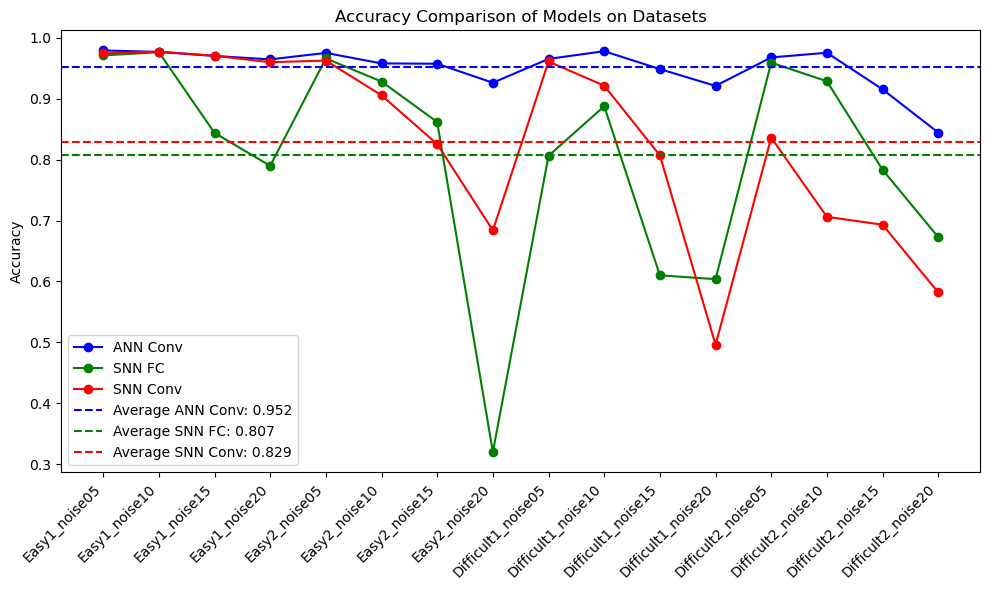

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋
filename_for_plot = [
    "Easy1_noise05", "Easy1_noise10", "Easy1_noise15", "Easy1_noise20",
    "Easy2_noise05", "Easy2_noise10", "Easy2_noise15", "Easy2_noise20",
    "Difficult1_noise05", "Difficult1_noise10", "Difficult1_noise15", "Difficult1_noise20",
    "Difficult2_noise05", "Difficult2_noise10", "Difficult2_noise15", "Difficult2_noise20"
]

# Accuracy 데이터
ANN_conv_accracy_set= [0.97935368, 0.97682709, 0.97028784, 0.96461825, 0.97524752, 0.95803571
, 0.95746785, 0.92628774, 0.965412,  0.97805344, 0.94869403, 0.92110454
, 0.96784232, 0.97551789, 0.91538462, 0.84446478]
SNN_fc_accuracy_set = [0.97114475, 0.97643732, 0.84400578, 0.78977821, 0.96616915, 0.92830189
, 0.86176032, 0.31984948, 0.80635401, 0.88769531, 0.61003861, 0.60377358
, 0.9592668,  0.92870999, 0.78333333, 0.67271859]
SNN_conv_accuracy_set = [0.97445601, 0.97737983, 0.97063072, 0.95998071, 0.96268657, 0.90566038
, 0.82545997, 0.68391345, 0.96116994, 0.92138672, 0.80694981, 0.49602781
, 0.83604888, 0.70611057, 0.69313725, 0.5819398 ]

# 평균 계산
average_ANN_conv = np.mean(ANN_conv_accracy_set)
average_SNN_fc = np.mean(SNN_fc_accuracy_set)
average_SNN_conv = np.mean(SNN_conv_accuracy_set)

# 데이터 준비
accuracies = np.array([ANN_conv_accracy_set, SNN_fc_accuracy_set, SNN_conv_accuracy_set])
averages = np.array([average_ANN_conv, average_SNN_fc, average_SNN_conv])

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 각 모델의 정확도 플롯
ax.plot(accuracies[0], label='ANN Conv', marker='o', linestyle='-', color='blue')
ax.plot(accuracies[1], label='SNN FC', marker='o', linestyle='-', color='green')
ax.plot(accuracies[2], label='SNN Conv', marker='o', linestyle='-', color='red')

# 평균값 플롯
ax.axhline(y=average_ANN_conv, color='blue', linestyle='--', label=f'Average ANN Conv: {average_ANN_conv:.3f}')
ax.axhline(y=average_SNN_fc, color='green', linestyle='--', label=f'Average SNN FC: {average_SNN_fc:.3f}')
ax.axhline(y=average_SNN_conv, color='red', linestyle='--', label=f'Average SNN Conv: {average_SNN_conv:.3f}')

# 레이블 추가
ax.set_xticks(np.arange(len(filename_for_plot)))
ax.set_xticklabels(filename_for_plot, rotation=45, ha='right')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison of Models on Datasets')
ax.legend()

plt.tight_layout()
plt.show()


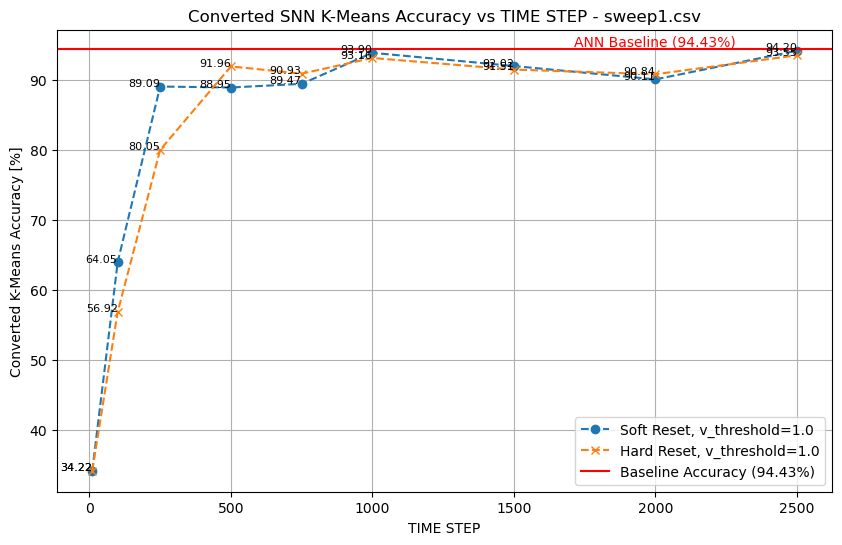

In [ ]:
import csv
import matplotlib.pyplot as plt
import os  # 파일 경로 처리를 위한 모듈

# CSV 파일 경로
# csv_file_path = "/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/ae_test_deprecated/250115/sweep0_vth_mul.csv" # vth_mul해서 sweep 돌린거
csv_file_path = "/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/ae_test_deprecated/250115/sweep1.csv"  #vth_mul안한거

# 결과를 저장할 리스트
tuple_list = []

# CSV 파일 읽기
with open(csv_file_path, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        try:
            # v_threshold, TIME, v_reset, converted_k_means_acc 값을 가져와 튜플로 변환
            v_threshold = float(row["v_threshold"])
            time = int(row["TIME"])
            v_reset = int(row["v_reset"])
            converted_k_means_acc = float(row["converted_k_means_acc"]) if row["converted_k_means_acc"] else None

            # 튜플 형태로 추가 (값이 None일 경우 처리할 수도 있음)
            tuple_list.append((v_threshold, time, v_reset, converted_k_means_acc))
        except ValueError as e:
            print(f"Error processing row {row}: {e}")

# 데이터를 TIME 기준으로 정렬
tuple_list.sort(key=lambda x: x[1])  # TIME을 기준으로 오름차순 정렬

# reset 방식에 따라 데이터를 나누기
soft_reset = [t for t in tuple_list if t[2] == 0]
hard_reset = [t for t in tuple_list if t[2] == 10000]

# reset 방식과 v_threshold에 따라 색상 설정
def plot_data(data, label_prefix, marker):
    for v_threshold in [1.0]:  # v_threshold 기준으로 제한
        filtered_data = [(t[1], t[3]) for t in data if t[0] == v_threshold]
        if filtered_data:  # 해당 v_threshold 데이터가 있을 경우만 플롯
            times, accuracies = zip(*filtered_data)  # x축(TIME), y축(converted_k_means_acc)
            
            plt.plot(
                times,
                accuracies,
                marker,
                label=f"{label_prefix}, v_threshold={v_threshold}",
                linestyle="--",
            )
            # 각 점에 accuracy 표시
            for time, acc in filtered_data:
                if acc == None:
                    continue
                plt.text(time, acc, f"{acc:.2f}", fontsize=8, ha="right")

# 그래프 초기화
plt.figure(figsize=(10, 6))

# soft_reset (v_reset=0) 데이터 플롯
plot_data(soft_reset, "Soft Reset", "o")

# hard_reset (v_reset=10000) 데이터 플롯
plot_data(hard_reset, "Hard Reset", "x")

# baseline accuracy 가로선 추가
baseline_accuracy = 94.43
plt.axhline(y=baseline_accuracy, color="red", linestyle="-", label=f"Baseline Accuracy ({baseline_accuracy}%)")
# baseline 텍스트 추가
plt.text(
    2000,  # x축 위치 (그래프 오른쪽 끝)
    baseline_accuracy + 0.4,  # y축 위치 (baseline 위 약간)
    f"ANN Baseline ({baseline_accuracy}%)",
    color="red",
    fontsize=10,
    ha="center",
)

# CSV 파일 이름 가져오기
csv_file_name = os.path.basename(csv_file_path)

# 그래프 세부 설정
plt.title(f"Converted SNN K-Means Accuracy vs TIME STEP - {csv_file_name}")
plt.xlabel("TIME STEP")
plt.ylabel("Converted K-Means Accuracy [%]")
plt.legend(loc="lower right")  # 범례를 오른쪽 아래로 이동
plt.grid(True)

# 그래프 출력
plt.show()
